[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module5_Files/Tokenizer_FFNN_Storms.ipynb)

# Tokenizer and FFNNs (feature engineering a sequence!)
**Dr. Dave Wanik - University of Connecticut**

Keras isn't a full-blown NLP library (you'll want to use Spacy or NLTK for that). But it does have quite a bit that makes it easy to get up and running with text sequence data (for now, we ignore the sequence and create features for modeling like count of words in each document (sample) or the TF_IDF (which penalizes for length of document in addition to frequency).

![alt text](https://pbs.twimg.com/media/D7l5pgDXsAAMX98.jpg)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import json
import numpy as np

## Read the data

In [ ]:
# we will read the file directly from this link
# url = "https://drive.google.com/uc?export=download&id=1jvIwUFVMZE7bQwGQeiu1yT6CSIdieu6_"

# Link to the data file on Github
url = "https://raw.githubusercontent.com/drdave-teaching/OPIM5509Files/refs/heads/main/OPIM5509_Module5_Files/StormEvents_2019.csv"

df = pd.read_csv(url, header = 0) # this means there is a header in the first row
df = pd.DataFrame(df)
df.head()

,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,137295,824116,TEXAS,48,2019,May,Flash Flood,BEXAR,5/9/2019 15:54,CST-6,...,N,LEON SPGS,NNE,SAN GERONIMO,29.7898,-98.6406,29.7158,-98.7744,Thunderstorms developed along a cold front as ...,Thunderstorms produced heavy rain that led to ...
1,140217,843354,MINNESOTA,27,2019,July,Thunderstorm Wind,PINE,7/15/2019 16:40,CST-6,...,E,ROCK CREEK,E,ROCK CREEK,45.7700,-92.8700,45.7700,-92.8700,An area of low pressure over southern Manitoba...,A 14-inch tree fell due to the winds and damag...
2,142648,861581,TEXAS,48,2019,October,Thunderstorm Wind,VAN ZANDT,10/20/2019 22:23,CST-6,...,N,EDGEWOOD,N,EDGEWOOD,32.7100,-95.8800,32.7100,-95.8800,Thunderstorms erupted across the DFW Metroplex...,A trained spotter measured a wind gust of 67 M...
3,142648,861584,TEXAS,48,2019,October,Thunderstorm Wind,TARRANT,10/20/2019 23:12,CST-6,...,WSW,AZLE,WSW,AZLE,32.8700,-97.6100,32.8700,-97.6100,Thunderstorms erupted across the DFW Metroplex...,The local police department reported a wind gu...
4,142648,861582,TEXAS,48,2019,October,Thunderstorm Wind,PALO PINTO,10/20/2019 22:36,CST-6,...,N,MINERAL WELLS,N,MINERAL WELLS,32.8000,-98.1000,32.8000,-98.1000,Thunderstorms erupted across the DFW Metroplex...,A wind gust of 75 MPH was measured by the Auto...


In [ ]:
# shuffle the data inplace
df = df.sample(frac=1).reset_index(drop=True)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61324 entries, 0 to 61323
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EPISODE_ID         61324 non-null  int64  
 1   EVENT_ID           61324 non-null  int64  
 2   STATE              61324 non-null  object 
 3   STATE_FIPS         61324 non-null  int64  
 4   YEAR               61324 non-null  int64  
 5   MONTH_NAME         61324 non-null  object 
 6   EVENT_TYPE         61324 non-null  object 
 7   CZ_NAME            61324 non-null  object 
 8   BEGIN_DATE_TIME    61324 non-null  object 
 9   CZ_TIMEZONE        61324 non-null  object 
 10  END_DATE_TIME      61324 non-null  object 
 11  INJURIES_DIRECT    61324 non-null  int64  
 12  INJURIES_INDIRECT  61324 non-null  int64  
 13  DEATHS_DIRECT      61324 non-null  int64  
 14  DEATHS_INDIRECT    61324 non-null  int64  
 15  DAMAGE_PROPERTY    49501 non-null  object 
 16  DAMAGE_CROPS       499

,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,136024,816247,NORTH DAKOTA,38,2019,May,Hail,NELSON,5/15/2019 18:08,CST-6,...,W,PELTO,W,PELTO,48.1400,-98.3500,48.1400,-98.3500,"By 4 pm on May 15th, temperatures across easte...",Dime to quarter sized hail fell.
1,142751,856849,NEW YORK,36,2019,October,Flood,MONTGOMERY,10/17/2019 8:03,EST-5,...,N,CANAJOHARIE,N,CANAJOHARIE,42.9086,-74.5708,42.9085,-74.5700,A strengthening low pressure system and cold f...,Riverfront Park was flooded near the Canajohar...
2,139212,838361,NORTH CAROLINA,37,2019,June,Thunderstorm Wind,ANSON,6/22/2019 16:10,EST-5,...,N,WADESBORO,N,WADESBORO,34.9862,-80.1025,34.9862,-80.1025,A mesoscale convective system moved across far...,Trees were reported down on North Carolina Hig...
3,139447,838812,GULF OF MEXICO,85,2019,June,Marine Thunderstorm Wind,COASTAL WATERS FROM INTRACOASTAL CITY TO CAMER...,6/25/2019 16:42,CST-6,...,SW,CAMERON,SW,CAMERON,29.7676,-93.3428,29.7676,-93.3428,Scattered storms across the coastal waters pro...,NaN
4,142499,858608,MASSACHUSETTS,25,2019,October,High Wind,EASTERN ESSEX,10/17/2019 1:45,EST-5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A powerful coastal storm developed along the N...,In Rockport there was a wind gust of 69 mph.


In [ ]:
# return complete cases
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28966 entries, 1 to 61320
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EPISODE_ID         28966 non-null  int64  
 1   EVENT_ID           28966 non-null  int64  
 2   STATE              28966 non-null  object 
 3   STATE_FIPS         28966 non-null  int64  
 4   YEAR               28966 non-null  int64  
 5   MONTH_NAME         28966 non-null  object 
 6   EVENT_TYPE         28966 non-null  object 
 7   CZ_NAME            28966 non-null  object 
 8   BEGIN_DATE_TIME    28966 non-null  object 
 9   CZ_TIMEZONE        28966 non-null  object 
 10  END_DATE_TIME      28966 non-null  object 
 11  INJURIES_DIRECT    28966 non-null  int64  
 12  INJURIES_INDIRECT  28966 non-null  int64  
 13  DEATHS_DIRECT      28966 non-null  int64  
 14  DEATHS_INDIRECT    28966 non-null  int64  
 15  DAMAGE_PROPERTY    28966 non-null  object 
 16  DAMAGE_CROPS       289

# Splitting Data

In [ ]:
df.head()

,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
1,142751,856849,NEW YORK,36,2019,October,Flood,MONTGOMERY,10/17/2019 8:03,EST-5,...,N,CANAJOHARIE,N,CANAJOHARIE,42.9086,-74.5708,42.9085,-74.5700,A strengthening low pressure system and cold f...,Riverfront Park was flooded near the Canajohar...
2,139212,838361,NORTH CAROLINA,37,2019,June,Thunderstorm Wind,ANSON,6/22/2019 16:10,EST-5,...,N,WADESBORO,N,WADESBORO,34.9862,-80.1025,34.9862,-80.1025,A mesoscale convective system moved across far...,Trees were reported down on North Carolina Hig...
6,134696,811324,OHIO,39,2019,April,Thunderstorm Wind,TRUMBULL,4/14/2019 17:37,EST-5,...,SSE,CHURCHILL,SSE,CHURCHILL,41.1400,-80.6500,41.1400,-80.6500,A warm front lifted northward across the regio...,A tree fell on a garage on 5th Ave in Liberty ...
7,138061,829681,NEW MEXICO,35,2019,July,Hail,RIO ARRIBA,7/24/2019 14:48,MST-7,...,WNW,COYOTE,WNW,COYOTE,36.1900,-106.7000,36.1900,-106.7000,A thunderstorm that developed over the Jemez M...,Local news outlet relayed a report near Coyote...
8,136934,821675,DELAWARE,10,2019,June,Flash Flood,NEW CASTLE,6/20/2019 0:20,EST-5,...,N,DUROSS HGTS,N,DUROSS HGTS,39.6944,-75.6181,39.6912,-75.6179,Showers and thunderstorms produced heavy rainf...,Airport Road to the north of the New Castle Ai...


In [ ]:
# since we have shuffled, we can specify X and Y then split
X = df['EVENT_NARRATIVE']
y = df['EVENT_TYPE']
print(X.shape, y.shape)

(28966,) (28966,)


In [ ]:
y.nunique()

15

In [ ]:
y.value_counts()

Thunderstorm Wind           13178
Flood                        4253
Flash Flood                  3851
Hail                         2755
Marine Thunderstorm Wind     1537
Tornado                      1329
Heavy Rain                   1101
Lightning                     300
Funnel Cloud                  268
Debris Flow                   168
Waterspout                    145
Marine High Wind               47
Marine Strong Wind             16
Marine Hail                    12
Dust Devil                      6
Name: EVENT_TYPE, dtype: int64

# LabelEncoder() for Y

In [ ]:
lb = LabelEncoder()
y = lb.fit_transform(y)
y = keras.utils.to_categorical(y)
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
lb_name_mapping = dict(zip(lb.classes_, lb.transform(lb.classes_)))
print(lb_name_mapping)

{'Debris Flow': 0, 'Dust Devil': 1, 'Flash Flood': 2, 'Flood': 3, 'Funnel Cloud': 4, 'Hail': 5, 'Heavy Rain': 6, 'Lightning': 7, 'Marine Hail': 8, 'Marine High Wind': 9, 'Marine Strong Wind': 10, 'Marine Thunderstorm Wind': 11, 'Thunderstorm Wind': 12, 'Tornado': 13, 'Waterspout': 14}


In [ ]:
y[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

# Tokenizer()

In [ ]:
# fit CountVectorizer! just accept the defaults for now (you can always play)
# check documentation for Tokenizer - it's awesome! https://keras.io/api/preprocessing/text/
from keras.preprocessing.text import Tokenizer
t = Tokenizer(num_words=10000) # play with this! 100, 1000, 10000... or leave default (nwords - 1)
t.fit_on_texts(X)
# summarize what was learned
print(t.word_counts)
print(t.document_count)
print(t.word_index)
print(t.word_docs)

OrderedDict([('riverfront', 18), ('park', 656), ('was', 12947), ('flooded', 2046), ('near', 6374), ('the', 31347), ('canajoharie', 1), ('creek', 1714), ('and', 17688), ('mohawk', 5), ('river', 4148), ('trees', 7310), ('were', 9630), ('reported', 7403), ('down', 8536), ('on', 9189), ('north', 1894), ('carolina', 36), ('highway', 3437), ('742', 2), ('a', 20485), ('tree', 5927), ('fell', 1399), ('garage', 138), ('5th', 60), ('ave', 320), ('in', 12964), ('liberty', 35), ('township', 548), ('local', 508), ('news', 39), ('outlet', 15), ('relayed', 294), ('report', 1029), ('coyote', 5), ('of', 23890), ('nickel', 275), ('size', 1479), ('hail', 2750), ('twitter', 111), ('airport', 611), ('road', 8265), ('to', 10054), ('new', 313), ('castle', 21), ('closed', 2272), ('around', 1148), ('nonesuch', 1), ('due', 2370), ('flash', 951), ('flooding', 5341), ('at', 9568), ('point', 300), ('judith', 4), ('there', 884), ('68', 108), ('mph', 3119), ('wind', 3912), ('gust', 2639), ('asos', 231), ('measured',

# Integer Encode
Play with the mode! Many options here.

* ‘binary‘: Whether or not each word is present in the document. This is the default.
* ‘count‘: The count of each word in the document.
* ‘tfidf‘: The Text Frequency-Inverse DocumentFrequency (TF-IDF) scoring for each word in the document.
* ‘freq‘: The frequency of each word as a ratio of words within each document.

Read Brownlee for more details: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/

Documentation for arguments available to you: https://keras.io/api/preprocessing/text/

Try playing with 100 vs. 1000 vs. 10000 `num_words` (in the `Tokenizer()`) and see how your results may or may not change... just because you have all the data doesn't mean you have to use it.

**NOTE:** Sequence length simply doesn't matter here - in fact, you are destroying the order of the sequence. You are creating features for modeling. Instead of a FFNN, you could use a random forest below (but warning, it probs will take a long time to fit).

In [ ]:
# integer encode documents
encoded_docs = t.texts_to_matrix(X, mode='tfidf') # try changing this to 'tfidf' vs. 'count'
print(encoded_docs)

[[0.         1.17457183 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         1.98872298 1.13883893 ... 0.         0.         0.        ]
 [0.         1.17457183 1.13883893 ... 0.         0.         0.        ]
 [0.         1.17457183 0.         ... 0.         0.         0.        ]]


# Visualization with PCA and t_SNE
Let's visualize how the data looks! For simplicity, we will only use two categories.

More here: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

And here: https://www.datacamp.com/community/tutorials/introduction-t-sne

In [ ]:
# subset
sub_df = df[(df['EVENT_TYPE'] == 'Hail') | (df['EVENT_TYPE'] == 'Flash Flood')]
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6606 entries, 7 to 61317
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EPISODE_ID         6606 non-null   int64  
 1   EVENT_ID           6606 non-null   int64  
 2   STATE              6606 non-null   object 
 3   STATE_FIPS         6606 non-null   int64  
 4   YEAR               6606 non-null   int64  
 5   MONTH_NAME         6606 non-null   object 
 6   EVENT_TYPE         6606 non-null   object 
 7   CZ_NAME            6606 non-null   object 
 8   BEGIN_DATE_TIME    6606 non-null   object 
 9   CZ_TIMEZONE        6606 non-null   object 
 10  END_DATE_TIME      6606 non-null   object 
 11  INJURIES_DIRECT    6606 non-null   int64  
 12  INJURIES_INDIRECT  6606 non-null   int64  
 13  DEATHS_DIRECT      6606 non-null   int64  
 14  DEATHS_INDIRECT    6606 non-null   int64  
 15  DAMAGE_PROPERTY    6606 non-null   object 
 16  DAMAGE_CROPS       6606

In [ ]:
# encode docs
sub_encoded_docs = t.texts_to_matrix(sub_df['EVENT_NARRATIVE'], mode='tfidf')

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns



In [ ]:
# PCA example
pca = PCA(n_components=50)
pca_result = pca.fit_transform(sub_encoded_docs)
tmp = pd.DataFrame(columns={'pca-one', 'pca-two', 'pca-three'})
tmp['pca-one'] = pca_result[:,0]
tmp['pca-two'] = pca_result[:,1]
tmp['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
tmp.head()

Explained variation per principal component: [0.03576792 0.01621276 0.01086517 0.0072484  0.00666975 0.00616058
 0.00591357 0.00570331 0.00560874 0.00533713 0.00519297 0.00502043
 0.00494161 0.00468927 0.00442696 0.00428226 0.00415629 0.00402579
 0.0038977  0.00382282 0.00373318 0.00361035 0.0035395  0.00343112
 0.00341354 0.00338014 0.00328587 0.00325216 0.00316949 0.00313937
 0.00309715 0.00298071 0.00294617 0.00289187 0.00286168 0.00284249
 0.00278695 0.00276371 0.00273272 0.00266453 0.00262701 0.00257904
 0.00252805 0.00252283 0.00246607 0.00244184 0.00241885 0.00238517
 0.00237225 0.00233941]


,pca-one,pca-two,pca-three
0,-2.427193,1.979719,0.363708
1,1.752571,-1.248268,-1.862173
2,-1.144418,-1.591116,-1.161606
3,0.598994,-1.411456,-1.276399
4,0.087035,-2.218671,-0.786184


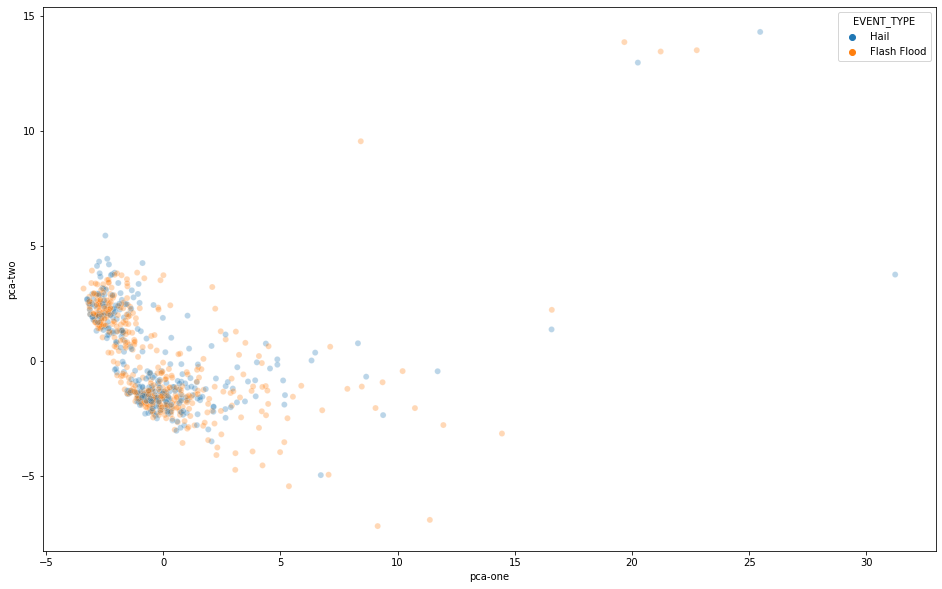

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tmp["pca-one"], y=tmp["pca-two"],
    hue=sub_df['EVENT_TYPE'],
    data=tmp,
    legend="full",
    alpha=0.3
)

# doesn't look great!

In [ ]:
# instead let's try with PCA as input (with a random sample, since takes a lot of time)
from time import time
time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6606 samples in 0.001s...
[t-SNE] Computed neighbors for 6606 samples in 1.179s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6606
[t-SNE] Computed conditional probabilities for sample 2000 / 6606
[t-SNE] Computed conditional probabilities for sample 3000 / 6606
[t-SNE] Computed conditional probabilities for sample 4000 / 6606
[t-SNE] Computed conditional probabilities for sample 5000 / 6606
[t-SNE] Computed conditional probabilities for sample 6000 / 6606
[t-SNE] Computed conditional probabilities for sample 6606 / 6606
[t-SNE] Mean sigma: 1.613433
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.351234
[t-SNE] KL divergence after 300 iterations: 2.070040
t-SNE done! Time elapsed: 24.149585485458374 seconds


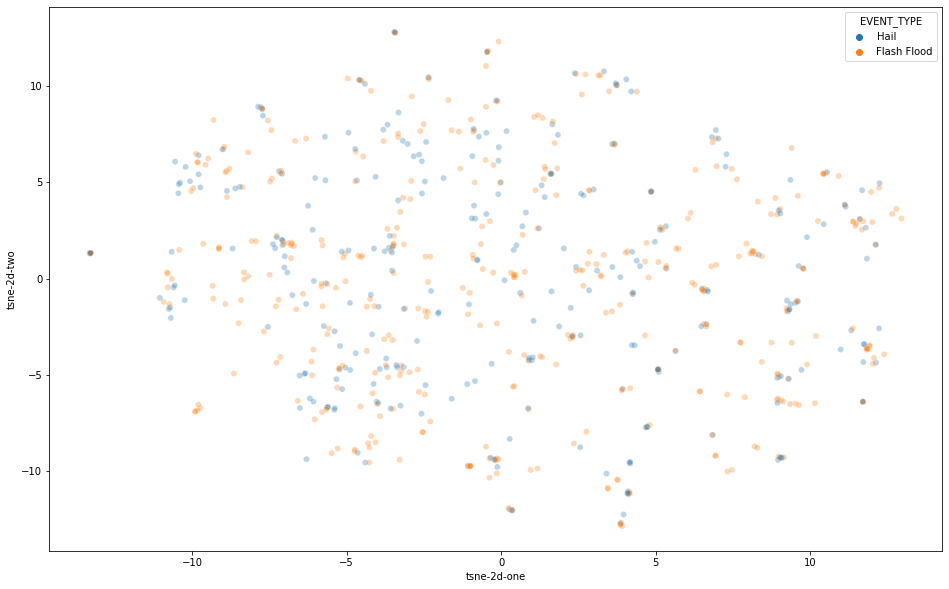

In [ ]:
tmp['tsne-2d-one'] = tsne_results[:,0]
tmp['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tmp["tsne-2d-one"], y=tmp["tsne-2d-two"],
    hue=sub_df['EVENT_TYPE'],
    legend="full",
    alpha=0.3
)

# Train and Test Partition

In [ ]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(encoded_docs, y,
                                                    random_state=42,
                                                    train_size=0.7)
print(encoded_docs.shape) # original TFIDF
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(28966, 10000)
(20276, 10000) (20276, 15)
(8690, 10000) (8690, 15)


# Fit the model!

In [ ]:
# look how we can be smarter about the last dense layer
n_outputs = y.shape[1]
print(n_outputs)

15


In [ ]:
# check X shape
print(X_train.shape)

(20276, 10000)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               1000100   
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 15)                1515      
                                                                 
Total params: 1,011,715
Trainable params: 1,011,715
Non-trainable params: 0
_________________________________________________________________


## (optional) Class Weights
* https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=100,
                    validation_data=(X_test, y_test))

# of course, you may use early stopping!

Epoch 1/10
203/203 [==============================] - 4s 20ms/step - loss: 0.0673 - accuracy: 0.9793 - val_loss: 0.3194 - val_accuracy: 0.9229
Epoch 2/10
203/203 [==============================] - 5s 25ms/step - loss: 0.0619 - accuracy: 0.9812 - val_loss: 0.3225 - val_accuracy: 0.9229
Epoch 3/10
203/203 [==============================] - 4s 20ms/step - loss: 0.0553 - accuracy: 0.9821 - val_loss: 0.3330 - val_accuracy: 0.9238
Epoch 4/10
203/203 [==============================] - 4s 20ms/step - loss: 0.0537 - accuracy: 0.9832 - val_loss: 0.3430 - val_accuracy: 0.9239
Epoch 5/10
203/203 [==============================] - 4s 21ms/step - loss: 0.0467 - accuracy: 0.9862 - val_loss: 0.3650 - val_accuracy: 0.9212
Epoch 6/10
203/203 [==============================] - 6s 30ms/step - loss: 0.0433 - accuracy: 0.9855 - val_loss: 0.3849 - val_accuracy: 0.9219
Epoch 7/10
203/203 [==============================] - 4s 21ms/step - loss: 0.0425 - accuracy: 0.9869 - val_loss: 0.3917 - val_accuracy: 0.9223

# Evaluate!

In [ ]:
# stealing this from our other scripts
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

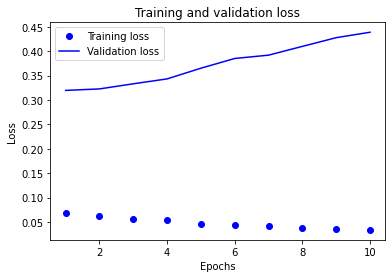

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

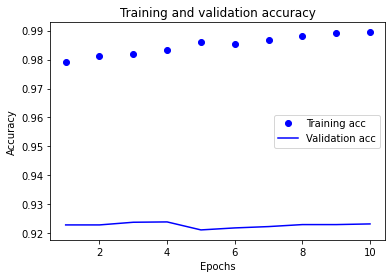

In [ ]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# classification report and confusion matrix
from sklearn.metrics import confusion_matrix

# see how the model did!
# if you don't round to a whole number (0 or 1), the confusion matrix won't work!
preds = np.round(model.predict(X_test),0)
preds[0]


272/272 [==============================] - 2s 8ms/step


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [ ]:
# confusion matrix (tough to see... but most is on diagonal!)
matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
matrix

# look at documentation for conf matrix on sklearn if you have questions!

array([[  32,    0,    5,   12,    0,    1,    1,    0,    0,    0,    0,
           0,    1,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    1,    0,    0],
       [   8,    0,  919,  243,    0,    1,    9,    0,    0,    0,    0,
           0,    2,    0,    0],
       [   3,    0,  221, 1036,    0,    0,    4,    0,    0,    0,    0,
           0,    4,    0,    0],
       [   0,    0,    0,    0,   89,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   2,    0,    2,    1,    0,  800,    2,    0,    1,    0,    0,
           0,   20,    0,    0],
       [   1,    0,    7,    5,    0,    1,  305,    0,    0,    0,    0,
           0,    5,    0,    0],
       [   0,    0,    1,    0,    0,    0,    0,   80,    0,    0,    0,
           0,    1,    0,    0],
       [   0,    0,    0,    0,    0,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   0,    0,    0,    0,    0,

In [ ]:
# classification report (similar - need argmax!)
from sklearn.metrics import classification_report

# more detail on how well things were predicted
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.59      0.62      0.60        52
           1       0.00      0.00      0.00         1
           2       0.79      0.78      0.79      1182
           3       0.80      0.82      0.81      1268
           4       0.99      1.00      0.99        89
           5       0.97      0.97      0.97       828
           6       0.95      0.94      0.95       324
           7       1.00      0.98      0.99        82
           8       0.00      0.00      0.00         2
           9       0.91      0.50      0.65        20
          10       1.00      0.17      0.29         6
          11       0.94      0.96      0.95       473
          12       0.98      0.99      0.98      3935
          13       0.97      0.97      0.97       381
          14       1.00      0.91      0.96        47

    accuracy                           0.92      8690
   macro avg       0.79      0.71      0.73      8690
weighted avg       0.92   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# what were original labels?
# link: https://stackoverflow.com/questions/42196589/any-way-to-get-mappings-of-a-label-encoder-in-python-pandas
lb_name_mapping = dict(zip(lb.classes_, lb.transform(lb.classes_)))
print(lb_name_mapping)

{'Debris Flow': 0, 'Dust Devil': 1, 'Flash Flood': 2, 'Flood': 3, 'Funnel Cloud': 4, 'Hail': 5, 'Heavy Rain': 6, 'Lightning': 7, 'Marine Hail': 8, 'Marine High Wind': 9, 'Marine Strong Wind': 10, 'Marine Thunderstorm Wind': 11, 'Thunderstorm Wind': 12, 'Tornado': 13, 'Waterspout': 14}


It worked! If you want some more NLP customization (i.e. removing stopwords etc.), check out this article: https://machinelearningmastery.com/deep-learning-bag-of-words-model-sentiment-analysis/